In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import virtually.auxfuncs as aux

# Change to your data directory
basedir = Path('/Volumes/data-1/behavior/hakan')


### Load data

In [3]:
data_path = basedir/'Kucukdereli_atal_data/data_table_all_mice.h5'

data_df = pd.read_hdf(data_path, key='data')


In [4]:
# Additional imports and setting up the plots
from scipy.stats import pearsonr, linregress, ttest_rel, bartlett
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as plt

font = {'family' : 'sans',
        'weight' : 'regular',
        'size'   : 8}
plt.rc('font', **font)
plt.rc('axes', linewidth=0.8)

colors = {'gray':'#D4D4D4', 'darkgray':'#545454', 
          'male':'#FF5E74', 'male_light':'#FFABB6', 
          'female':'#00B7FF', 'female_light':'#9EE3FF'}


## Figures 2C and 2D

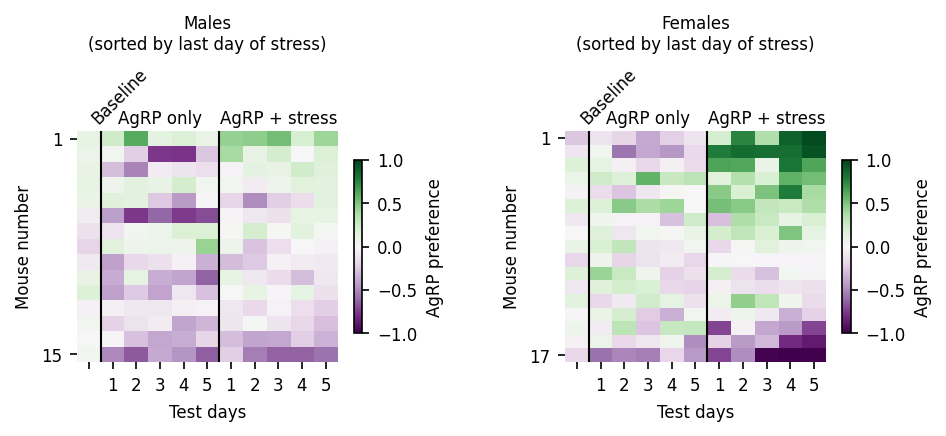

In [36]:
fig, axs = plt.subplots(1,2, figsize=(7,2), dpi=150)
fig.subplots_adjust(wspace=0.5)

for i, sex in enumerate(['male', 'female']):
    df = data_df.query('@data_df.mouse.sex==@sex').sort_values(('test_',5), ascending=False)
    pref_df = pd.concat([df['baseline'].mean(axis=1), df['test'], df['test_']], axis=1)
    
    ax = axs[i]

    hm = ax.imshow(pref_df, aspect='auto', cmap='PRGn', vmin=-1, vmax=1)

    ax.plot([0.5,0.5], ax.get_ybound(), color='k', linewidth=1)
    ax.plot([5.5,5.5], ax.get_ybound(), color='k', linewidth=1)

    ax.text(0, -0.75, 'Baseline', rotation=45, ha='left', va='bottom')
    ax.text(3, -0.75, 'AgRP only', ha='center', va='bottom')
    ax.text(8, -0.75, 'AgRP + stress', ha='center', va='bottom')

    ax.axes.spines[:].set_visible(False)

    ax.set_xlabel('Test days')
    ax.set_xticks(np.arange(len(pref_df.columns)))
    ax.set_xticklabels(['','1','2','3','4','5','1','2','3','4','5'])

    ax.set_ylabel('Mouse number')
    ax.set_yticks([0,len(pref_df)-1])
    ax.set_yticklabels([1,len(pref_df)])

    ax.set_title(f'{sex[0].upper()}{sex[1:]}s\n(sorted by last day of stress)', y=1.3, fontsize=8)

    fig.colorbar(hm, ax=ax, label='AgRP preference', shrink=0.75)


## Figures 2E and 2F

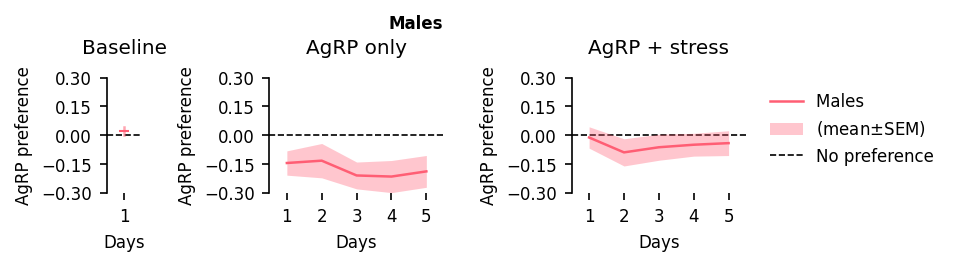

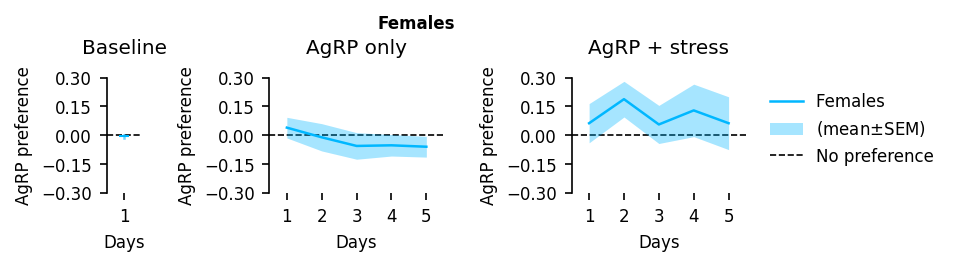

In [183]:
titles = {'baseline':'Baseline', 'test':'AgRP only', 'test_':'AgRP + stress'}

for sex in ['male','female']:
    fig, axs = plt.subplots(1,3, figsize=(5.5,1), dpi=150, gridspec_kw={'width_ratios': [1, 5, 5]})
    fig.subplots_adjust(wspace=1)
    fig.suptitle(f'{sex[0].upper()}{sex[1:]}s', y=1.3, fontsize=8, fontweight='bold')
    
    days = np.arange(1,6,1)

    ax = axs[0]
    df = data_df.query('@data_df.mouse.sex==@sex')['baseline'].mean(axis=1)
    ax.plot([1], df.mean(axis=0), color=colors[sex], linewidth=1.2, marker='_', markersize=5, zorder=1)
    ax.plot([1,1], [df.mean(axis=0)+df.mean(axis=0), df.mean(axis=0)-df.mean(axis=0)], color=colors[sex], linewidth=1.2, marker=None, markersize=8, alpha=0.55, clip_on=False, zorder=0)

    ax = axs[1]
    df = data_df.query('@data_df.mouse.sex==@sex')['test']
    ax.plot(days, df.mean(axis=0), color=colors[sex], linewidth=1.2, zorder=1)
    ax.fill_between(days, df.mean(axis=0)-df.sem(axis=0), df.mean(axis=0)+df.sem(axis=0), color=colors[sex], alpha=0.35, linewidth=0, clip_on=False, zorder=0)
    
    ax = axs[2]
    df = data_df.query('@data_df.mouse.sex==@sex')['test_']
    ax.plot(days, df.mean(axis=0), color=colors[sex], linewidth=1.2, zorder=1, label=f'{sex[0].upper()}{sex[1:]}s ')
    ax.fill_between(days, df.mean(axis=0)-df.sem(axis=0), df.mean(axis=0)+df.sem(axis=0), color=colors[sex], alpha=0.35, linewidth=0, clip_on=False, zorder=0, label=r'(mean$\pm$SEM)')
    
    for e, experiment in enumerate(['baseline','test','test_']):
        ax = axs[e]

        if experiment=='baseline':
            ax.plot([.5,1.5], [0,0], color='k', linewidth=0.8, linestyle='--', zorder=-1)
            ax.set_xticks([1])
            ax.set_xlim([.5,1.5])
        else:
            ax.plot([days[0]-.5,days[-1]+.5], [0,0], color='k', linewidth=0.8, linestyle='--', zorder=-1, label='No preference')
            ax.set_xticks(days)
            ax.set_xlim([days.min()-0.5, days.max()+0.5])

        ax.axes.spines[['top','right','bottom']].set_visible(False)

        ax.set_ylim([-0.3,0.3])
        ax.set_yticks([-0.3,-0.15,0,0.15,0.3])

        ax.set_xlabel("Days")
        ax.set_ylabel("AgRP preference")

        ax.set_title(f"{titles[experiment]}", y=1.1)

    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8, frameon=False)



## Figure S2E

### Plot the preferences from first and second sessions

Load the preference data for the first and second sessions. First session corresponds to the first half an hour of each day of RTPP before the 5-minute sham or repeated shock period. Second session corresponds to the second half an hour following the sham or repeated shock period. See Methods for more details. Specifically, see subsections *Virtual reality place-preference* and *Real-time place preference*.

In [12]:
# Load data for each sessions
sessions_df = {}
session_path = basedir/'Kucukdereli_atal_data/first_sessions_all_mice.h5'
sessions_df['session_1'] = pd.read_hdf(session_path, key='data').sort_values(('mouse','mouse'))

session_path = basedir/'Kucukdereli_atal_data/second_sessions_all_mice.h5'
sessions_df['session_2'] = pd.read_hdf(session_path, key='data').sort_values(('mouse','mouse'))


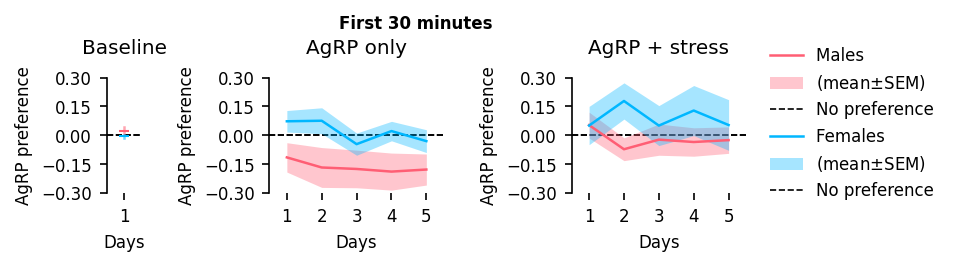

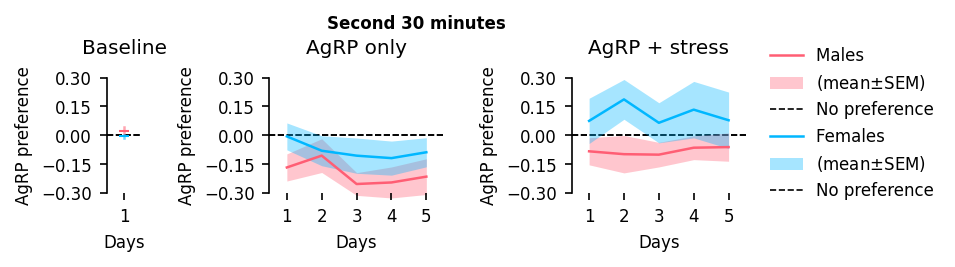

In [20]:
titles = {'baseline':'Baseline', 'test':'AgRP only', 'test_':'AgRP + stress'}
session_titles = ['First 30 minutes', 'Second 30 minutes']

for s, session in enumerate(['session_1','session_2']):
    fig, axs = plt.subplots(1,3, figsize=(5.5,1), dpi=150, gridspec_kw={'width_ratios': [1, 5, 5]})
    fig.subplots_adjust(wspace=1)
    fig.suptitle(f'{session_titles[s]}', y=1.3, fontsize=8, fontweight='bold')

    for sex in ['male','female']:

        
        days = np.arange(1,6,1)

        ax = axs[0]
        df = sessions_df[session].query('@data_df.mouse.sex==@sex')['baseline'].mean(axis=1)
        ax.plot([1], df.mean(axis=0), color=colors[sex], linewidth=1.2, marker='_', markersize=5, zorder=1)
        ax.plot([1,1], [df.mean(axis=0)+df.mean(axis=0), df.mean(axis=0)-df.mean(axis=0)], color=colors[sex], linewidth=1.2, marker=None, markersize=8, alpha=0.55, clip_on=False, zorder=0)

        ax = axs[1]
        df = sessions_df[session].query('@data_df.mouse.sex==@sex')['test']
        ax.plot(days, df.mean(axis=0), color=colors[sex], linewidth=1.2, zorder=1)
        ax.fill_between(days, df.mean(axis=0)-df.sem(axis=0), df.mean(axis=0)+df.sem(axis=0), color=colors[sex], alpha=0.35, linewidth=0, clip_on=False, zorder=0)
        
        ax = axs[2]
        df = sessions_df[session].query('@data_df.mouse.sex==@sex')['test_']
        ax.plot(days, df.mean(axis=0), color=colors[sex], linewidth=1.2, zorder=1, label=f'{sex[0].upper()}{sex[1:]}s ')
        ax.fill_between(days, df.mean(axis=0)-df.sem(axis=0), df.mean(axis=0)+df.sem(axis=0), color=colors[sex], alpha=0.35, linewidth=0, clip_on=False, zorder=0, label=r'(mean$\pm$SEM)')
        
        for e, experiment in enumerate(['baseline','test','test_']):
            ax = axs[e]

            if experiment=='baseline':
                ax.plot([.5,1.5], [0,0], color='k', linewidth=0.8, linestyle='--', zorder=-1)
                ax.set_xticks([1])
                ax.set_xlim([.5,1.5])
            else:
                ax.plot([days[0]-.5,days[-1]+.5], [0,0], color='k', linewidth=0.8, linestyle='--', zorder=-1, label='No preference')
                ax.set_xticks(days)
                ax.set_xlim([days.min()-0.5, days.max()+0.5])

            ax.axes.spines[['top','right','bottom']].set_visible(False)

            ax.set_ylim([-0.3,0.3])
            ax.set_yticks([-0.3,-0.15,0,0.15,0.3])

            ax.set_xlabel("Days")
            ax.set_ylabel("AgRP preference")

            ax.set_title(f"{titles[experiment]}", y=1.1)

        ax.legend(bbox_to_anchor=(1.05, 1.4), loc='upper left', fontsize=8, frameon=False)



## Figure 2G

In [352]:
variances = {}
for sex in ['male','female']:
    df = data_df.query('@data_df.mouse.sex==@sex')

    sample_n = len(df)
    # 10000
    variances[sex] = {'baseline':[], 'test':[], 'test_':[]}
    for n in range(10):
        variances[sex]['baseline'].append(df['baseline'].mean(axis=1).sample(sample_n, replace=True, random_state=n).var())
        variances[sex]['test'].append(df['test'].sample(sample_n, replace=True, random_state=n).var())
        variances[sex]['test_'].append(df['test_'].sample(sample_n, replace=True, random_state=n).var())
    pd.concat(variances['male']['test'], axis=1)
    pd.concat(variances['male']['test'], axis=1)
variances




# Reorganize the data
df = pd.concat([pd.DataFrame({'sex': data_df[('mouse', 'sex')],
                              'baseline': data_df['baseline'].mean(axis=1),
                              'test': data_df[('test', day)],
                              'test_': data_df[('test_', day)], 
                              'day': day}) for day in [1,2,3,4,5]], axis=0, ignore_index=True)

# Apply bootstrapping to estimate variance for both measurements by day and sex
variance_estimates = []
for day in df['day'].unique():
    for sex in ['male', 'female']:
        data = df[(df['day'] == day) & (df['sex'] == sex)]
        
        for n in range(10000):
            variance_baseline = data['baseline'].sample(data['baseline'].shape[0], replace=True, random_state=n).var()
            variance_test = data['test'].sample(data['test'].shape[0], replace=True, random_state=n).var()
            variance_test_ = data['test_'].sample(data['test_'].shape[0], replace=True, random_state=n).var()

            variance_estimates.append((day, sex, 'baseline', variance_baseline))
            variance_estimates.append((day, sex, 'test', variance_test))
            variance_estimates.append((day, sex, 'test_', variance_test_))

# Convert the results to a DataFrame
variance_df = pd.DataFrame(variance_estimates, columns=['day', 'sex', 'experiment', 'variance'])




titles = {'baseline':'Baseline', 'test':'AgRP only', 'test_':'AgRP + stress'}

fig, axs = plt.subplots(2,3,figsize=(8,6), dpi=150, gridspec_kw={'width_ratios':[1,5,5]})
fig.subplots_adjust(wspace=0.5, hspace=1)
for i, sex in enumerate(['male','female']):    
    variances, ci_dist = getVar_CI(regress_table, sex, n_shuffles=1000)
    l = len(regress_table[regress_table[('info_','sex')]==sex])
    print(f'{sex}: n= {l}')
    
    # Baseline
    ax = axs[i,0]
    n5, n95 = ci_dist.shape[0]*0.05, ci_dist.shape[0]*0.95
    yerr = [ci_dist.loc[n5, 'baseline'], ci_dist.loc[n95, 'baseline']]
    var_point = ax.errorbar(x=[0], y=variances['baseline'].to_numpy(), yerr=yerr, clip_on=False, color=aux.color(sex), ecolor=aux.color(sex),
                            marker='_', markersize=10, markeredgewidth=2, elinewidth=2)
    ax.set_xticks([0])
    ax.set_xticklabels([0], fontsize=14)
    ax.set_title('Baseline', y=1.2)

    






titles = {'baseline':'Baseline', 'test':'AgRP only', 'test_':'AgRP + stress'}

fig, axs = plt.subplots(2,3,figsize=(8,6), dpi=150, gridspec_kw={'width_ratios':[1,5,5]})
fig.subplots_adjust(wspace=0.5, hspace=1)
for i, sex in enumerate(['male','female']):    
    variances, ci_dist = getVar_CI(regress_table, sex, n_shuffles=1000)
    l = len(regress_table[regress_table[('info_','sex')]==sex])
    print(f'{sex}: n= {l}')
    
    # Baseline
    ax = axs[i,0]
    n5, n95 = ci_dist.shape[0]*0.05, ci_dist.shape[0]*0.95
    yerr = [ci_dist.loc[n5, 'baseline'], ci_dist.loc[n95, 'baseline']]
    var_point = ax.errorbar(x=[0], y=variances['baseline'].to_numpy(), yerr=yerr, clip_on=False, color=aux.color(sex), ecolor=aux.color(sex),
                            marker='_', markersize=10, markeredgewidth=2, elinewidth=2)
    ax.set_xticks([0])
    ax.set_xticklabels([0], fontsize=14);
    ax.set_title('Baseline', y=1.2)
    
    # AgRP only
    ax = axs[i,1]
#     n5, n95 = ci_dist.shape[0]*0.05, ci_dist.shape[0]*0.95
    ci = ci_dist.quantile([0.05, 0.95])

    var_line, = ax.plot(np.arange(5), variances['test'], color=aux.color(sex), clip_on=False, linewidth=2, label=f'Mean ({sex}s)')
    ci_shade = ax.fill_between(np.arange(5), ci.loc[0.05, 'test'], ci.loc[0.95, 'test'],
                               facecolor=aux.color(sex), linewidth=0, alpha=0.2, clip_on=False, label=f'95% CI ({sex}s)')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(np.arange(5)+1, fontsize=14);
    ax.set_title('AgRP only', y=1.2)
    
    # AgRP + Stress
    ax = axs[i,2]
    n5, n95 = ci_dist.shape[0]*0.05, ci_dist.shape[0]*0.95
    print(n5)
#     n5, n95 = np.quantile(ci_dist.to_numpy().flatten(), [0.05,0.95])
    var_line, = ax.plot(np.arange(5), variances['test_'], color=aux.color(sex), clip_on=False, linewidth=2)
    ci_shade = ax.fill_between(np.arange(5), ci_dist.loc[n5, 'test_'], ci_dist.loc[n95, 'test_'],
                               facecolor=aux.color(sex), linewidth=0, alpha=0.2, clip_on=False)
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(np.arange(5)+1, fontsize=14);
    ax.set_title('AgRP + Stress', y=1.2)
    
    for ax in axs.ravel():
        ax.set_ylabel('Variance of preference', fontsize=14)
        ax.set_xlabel('Days', fontsize=14)
        ax.xaxis.set_label_coords(0.5, -0.3)

        ax.set_yticks(np.arange(0,0.51,0.25))
        ax.set_yticklabels(np.round(np.arange(0,0.51,0.25),2), fontsize=14)
        ax.set_ylim([0,0.5])
        # ax.set_xbound(-1)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['bottom'].set_linewidth(1.5)

        ax.xaxis.set_tick_params(width=1.5)
        ax.yaxis.set_tick_params(width=1.5)

## Figure 2H

#### Factor analysis of preferences

In [166]:
# Additional imports
from sklearn.cluster import KMeans

from matplotlib import colormaps
colorpicpker = colormaps['PRGn_r']
cmap = colorpicpker([0,0.25,0.35,0.75,1])


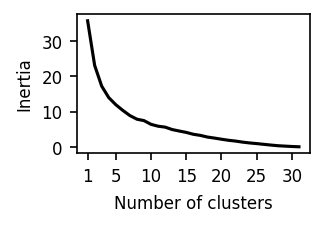

In [123]:
# Organize the data
pref_df = data_df[['mouse','baseline','test','test_']].copy()

# Get the intertia for all possible cluster numbers
inertia = []
for k in range(1, len(pref_df)):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(pref_df[['test','test_']])
    inertia.append(kmeans.inertia_)

fig, ax = plt.subplots(1,1,figsize=(2,1.2), dpi=150)
ax.plot(range(1, len(pref_df)), inertia, c='k')
ax.set_xticks([1,5,10,15,20,25,30])
ax.set_yticks([0,10,20,30])
ax.set_xlabel('Number of clusters')
# ax.set_ylabel('Cluster Compactness\n(Inertia)')
ax.set_ylabel('Inertia')

kmeans = KMeans(n_clusters=5, init='k-means++', n_init=1, random_state=2).fit(pref_df[['test','test_']])
pref_df.loc[:, ('kmeans','label')] = kmeans.labels_


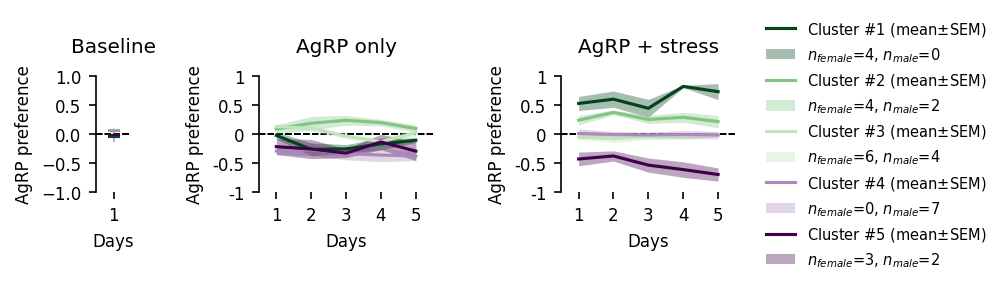

In [172]:
titles = {'baseline':'Baseline', 'test':'AgRP only', 'test_':'AgRP + stress'}

fig, axs = plt.subplots(1,3, figsize=(5.5,1), dpi=150, gridspec_kw={'width_ratios': [1, 5, 5]})
fig.subplots_adjust(wspace=1)

label_idx = pref_df.groupby(('kmeans','label'))[[('test_',5)]].mean().sort_values(by=('test_',5), ascending=False).index
for i, idx in enumerate(label_idx):
    df = pref_df.query("@pref_df.kmeans.label==@idx")
    n_male = np.sum(df.mouse.sex=='male')
    n_female = np.sum(df.mouse.sex=='female')

    # Baseline
    ax = axs[0]

    mean = df['baseline'].mean(axis=1).mean(axis=0)
    sem = df['baseline'].mean(axis=1).sem(axis=0)

    ax.fill_between([1], mean-sem, mean+sem, color=cmap[i], alpha=0.35)
    ax.plot([1], mean, color=cmap[i], marker='_')
    ax.set_ylim([-1,1])
    ax.set_xlim([0.5,1.5])
    ax.set_xticks([1])

    # AgRP only  
    ax = axs[1]

    mean = df['test'].mean(axis=0)
    sem = df['test'].sem(axis=0)   
    ax.plot(mean, color=cmap[i])
    ax.fill_between([1,2,3,4,5], mean-sem, mean+sem, color=cmap[i], linewidth=0, alpha=0.35)

    ax.set_ylim([-1,1])
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_yticklabels([-1,-0.5,0,0.5,1], fontsize=8)
    ax.set_xlim([0.5,5.5])
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5], fontsize=8)

    # AgRP + stress
    ax = axs[2]
    
    mean = df['test_'].mean(axis=0)
    sem = df['test_'].sem(axis=0)   
    ax.plot(mean, color=cmap[i], label=f'Cluster #{i+1} (mean'+r'$\pm$SEM)')
    ax.fill_between([1,2,3,4,5], mean-sem, mean+sem, color=cmap[i], linewidth=0, alpha=0.35, label=r'$n_{female}$'+f'={n_female}, ' + r'$n_{male}$' + f'={n_male} ')
    
    ax.set_ylim([-1,1])
    ax.set_yticks([-1,-0.5,0,0.5,1])
    ax.set_yticklabels([-1,-0.5,0,0.5,1], fontsize=8)
    ax.set_xlim([0.5,5.5])
    ax.set_xticks([1,2,3,4,5])
    ax.set_xticklabels([1,2,3,4,5], fontsize=8)

    for e, experiment in enumerate(['baseline','test','test_']):
        ax = axs[e]

        if experiment=='baseline':
            ax.plot([.5,1.5], [0,0], color='k', linewidth=0.8, linestyle='--', zorder=-1)
            ax.set_xticks([1])
            ax.set_xlim([.5,1.5])
        else:
            ax.plot([days[0]-.5,days[-1]+.5], [0,0], color='k', linewidth=0.8, linestyle='--', zorder=-1)
            ax.set_xticks(days)
            ax.set_xlim([days.min()-0.5, days.max()+0.5])

        ax.axes.spines[['top','right','bottom']].set_visible(False)

        ax.set_ylim([-1,1])
        ax.set_yticks([-1,-0.5,0,0.5,1.0])

        ax.set_xlabel("Days")
        ax.set_ylabel("AgRP preference")

        ax.set_title(f"{titles[experiment]}", y=1.1)

axs[-1].legend(bbox_to_anchor=(1.1, 1.6), loc='upper left', frameon=False, fontsize=7)
